<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/25_mlb_swing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# font

In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '24px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

# mlb swing data

In [ ]:
!pip install pybaseball

<IPython.core.display.Javascript object>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 31.6 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
import math
import pybaseball as bb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import KFold
bb.cache.enable()

<IPython.core.display.Javascript object>

In [ ]:
def draw_sz(sz_top=3.5, sz_bot=1.5, ls='k-'):
  """
  draw strike zone
  draw the strike zone on a plot using mpl
  inputs:
    sz_top: top of strike zone (ft)
    sz_bot: bottom of strike zone (ft)
    ls: linestyle (use `plt.plot()` linestyle conventions)
  output:
    strike zone plot
  """
  plt.plot([-0.708, 0.708], [sz_bot,sz_bot], ls)
  plt.plot([-0.708, -0.708], [sz_bot,sz_top], ls)
  plt.plot([0.708, 0.708], [sz_bot,sz_top], ls)
  plt.plot([-0.708, 0.708], [sz_top,sz_top], ls)

def draw_home_plate(catcher_perspective=True, ls='k-'):
  """
  draw home plate from either the catcher perspective or pitcher perspective
  inputs:
    catcher_perspective: orient home plate in the catcher POV. if False, orients
      home plate in the pitcher POV.
    ls: linestyle (use `plt.plot()` linestyle conventions)
  output:
    home plate plot
  """
  if catcher_perspective:
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,-0.3], ls)
    plt.plot([0.708, 0.708], [0,-0.3], ls)
    plt.plot([-0.708, 0], [-0.3, -0.6], ls)
    plt.plot([0.708, 0], [-0.3, -0.6], ls)
  else:
    plt.plot([-0.708, 0.708], [0,0], ls)
    plt.plot([-0.708, -0.708], [0,0.1], ls)
    plt.plot([0.708, 0.708], [0,0.1], ls)
    plt.plot([-0.708, 0], [0.1, 0.3], ls)
    plt.plot([0.708, 0], [0.1, 0.3], ls)

<IPython.core.display.Javascript object>

In [ ]:
df = bb.statcast(start_dt="2025-03-01", end_dt="2025-12-01")
df = df.reset_index(drop=True)
df['nw_max_impact'] = (df['release_speed'].add(df['bat_speed'])).mul(.8)
df['nw_impact'] = df['launch_speed'].div(df['nw_max_impact'])

model_data = df.dropna(subset=['attack_angle','launch_angle','nw_impact'])
folds = 3
kf = KFold(n_splits=folds, shuffle=True)
s = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train = model_data.iloc[train_idx]
  test = model_data.iloc[test_idx]
  model = RandomForestRegressor()
  model.fit(train.loc[:, ['attack_angle','launch_angle']], train['nw_impact'])
  _s = pd.Series(model.predict(test.loc[:, ['attack_angle','launch_angle']]), index=test.index)
  s = pd.concat([s,_s])
df['ximpact'] = s
df['ideal_launch_angle'] = ((df['attack_angle'].mul(1.05)).add(5))

# create a column called attack_zone
df['attack_zone'] = 'waste'
df.loc[(df['plate_x'].between(-0.558, 0.558)) & (df['plate_z'].between(1.833,3.166)), 'attack_zone'] = 'heart'
df.loc[(df['plate_x'].between(-1.108, 1.108)) & (df['plate_z'].between(1.166,3.833)) & (~df['attack_zone'].isin(['heart'])), 'attack_zone'] = 'shadow'
df.loc[(df['plate_x'].between(-1.666, 1.666)) & (df['plate_z'].between(0.5,4.5)) & (~df['attack_zone'].isin(['heart', 'shadow'])), 'attack_zone'] = 'chase'

df.shape

<IPython.core.display.Javascript object>

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


  0%|          | 0/246 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
/usr/local/lib/python3.11/dist-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = 

(342538, 123)

In [ ]:
df.[:, ['bb_type','delta_run_exp']]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

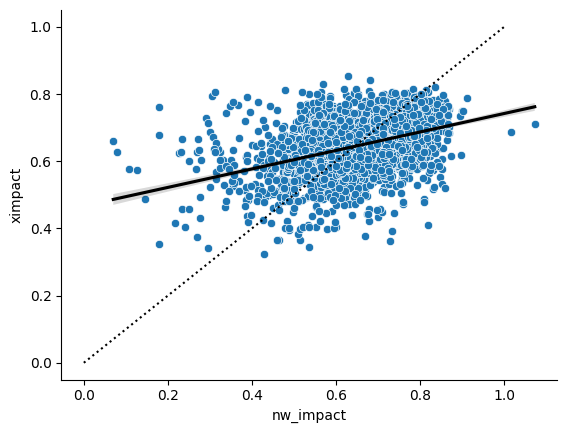

In [ ]:
_df = df.sample(10000)
sns.scatterplot(data=_df,x='nw_impact',y='ximpact')
sns.regplot(data=_df,x='nw_impact',y='ximpact',scatter=False,color='k')
plt.plot([0,1],[0,1],'k:')
sns.despine()
plt.show()


<IPython.core.display.Javascript object>

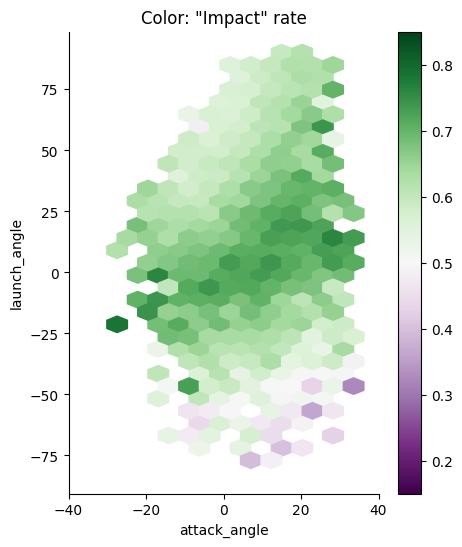

In [ ]:
x='attack_angle'
y='launch_angle'
hue='nw_impact'

fig = plt.figure(figsize=(5,6))
_df = df.dropna(subset=[x,y,hue]).sample(10000)
plt.hexbin(data=df.dropna(subset=[x,y,hue]).sample(10000),
           x=x, y=y, C=hue, cmap='PRGn',gridsize=30, mincnt=3,
           vmin=0.15, vmax=.85)
sns.despine()
plt.xlim(-40,40)
plt.title('''Color: "Impact" rate''')
plt.xlabel('attack_angle')
plt.ylabel('launch_angle')
plt.colorbar()
plt.show()

In [ ]:
feats = ['attack_angle']
target = 'launch_angle'
model_data = df.loc[(df['nw_impact']>.7) & (df['launch_angle']>5)]
model = LinearRegression()
model.fit(model_data.loc[:, feats], model_data[target])
model.coef_, model.intercept_

<IPython.core.display.Javascript object>

(array([0.43779511]), np.float64(21.176157117683758))

<IPython.core.display.Javascript object>

,ideal_launch_angle
count,136005.0
mean,14.439694
std,12.406102
min,-86.217417
25%,6.980774
50%,14.822786
75%,22.569002
max,95.55391


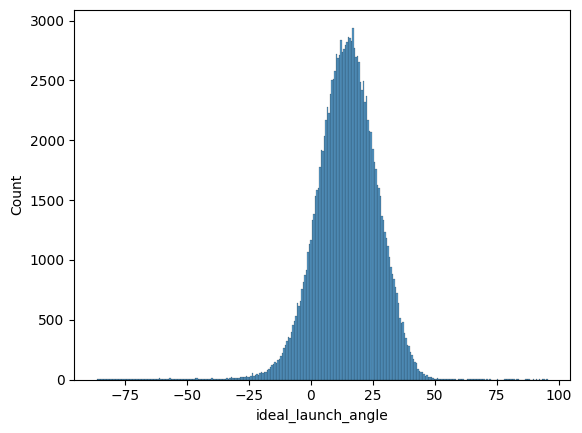

In [ ]:
sns.histplot(df['ideal_launch_angle'])
df['ideal_launch_angle'].describe()

<IPython.core.display.Javascript object>

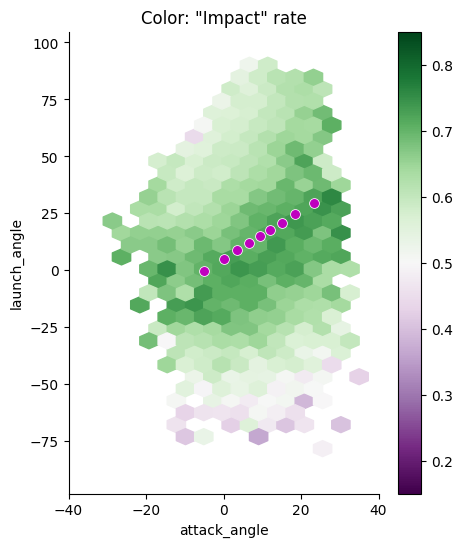

,q,ideal_launch_angle,attack_angle
0,0.0,-86.217417,-86.873731
1,0.1,-0.257444,-5.00709
2,0.2,5.031134,0.029652
3,0.3,8.730727,3.553073
4,0.4,11.856894,6.530376
5,0.5,14.822786,9.355034
6,0.6,17.690403,12.086098
7,0.7,20.849273,15.094546
8,0.8,24.479445,18.551852
9,0.9,29.523135,23.355367


In [ ]:
x='attack_angle'
y='launch_angle'
hue='nw_impact'

_q = df['ideal_launch_angle'].quantile(np.arange(0,1.1,.1)).to_frame().reset_index().rename(columns={'index':'q'})
_q2 = df['attack_angle'].quantile(np.arange(0,1.1,.1)).to_frame().reset_index().rename(columns={'index':'q'})
q = _q.merge(_q2)

fig = plt.figure(figsize=(5,6))
_df = df.dropna(subset=[x,y,hue]).sample(10000)
plt.hexbin(data=df.dropna(subset=[x,y,hue]).sample(10000),
           x=x, y=y, C=hue, cmap='PRGn',gridsize=30, mincnt=3,
           vmin=0.15, vmax=.85)
sns.scatterplot(data=q, x='attack_angle', y='ideal_launch_angle',
                color='m',s=50,legend=None,label=None)
sns.despine()
plt.xlim(-40,40)
plt.title('''Color: "Impact" rate''')
plt.xlabel('attack_angle')
plt.ylabel('launch_angle')
plt.colorbar()
plt.show()
q

In [ ]:
df['nw_carry'] = df['launch_angle'].add(90).div(df['ideal_launch_angle'].add(90))
df['nw_carry'] = df['nw_carry'].apply(np.log10)
df['nw_carry'] = (df['nw_carry'].add(2)).div(3)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

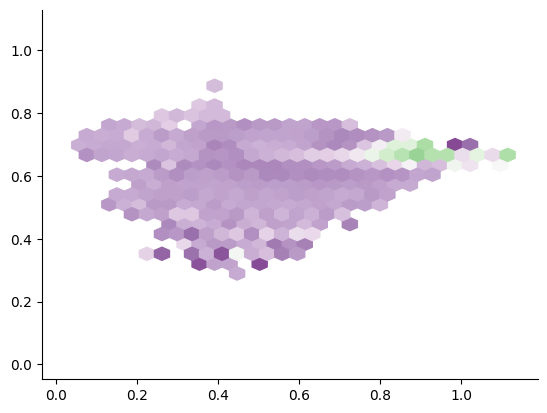

In [ ]:
df_plt = df.loc[df['description']=='hit_into_play']
hue='delta_run_exp'

# sns.scatterplot(data=df_plt,x='nw_impact',y='nw_carry',hue=hue, palette='PRGn')
# sns.regplot(data=df_plt,x='nw_impact',y='nw_carry',scatter=False,color='k')
# sns.despine()
# plt.show()

plt.hexbin(data=df,x='nw_impact',y='nw_carry',C=hue, cmap='PRGn', gridsize=30, mincnt=3, vmin=-.5,vmax=1)
sns.despine()
plt.show()

In [ ]:
162*.161

<IPython.core.display.Javascript object>

26.082

<IPython.core.display.Javascript object>

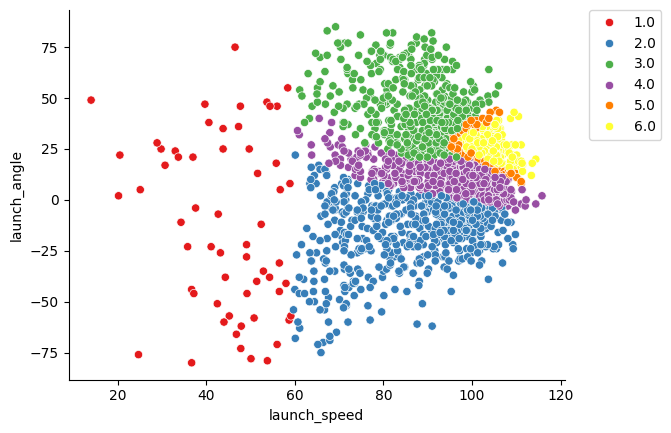

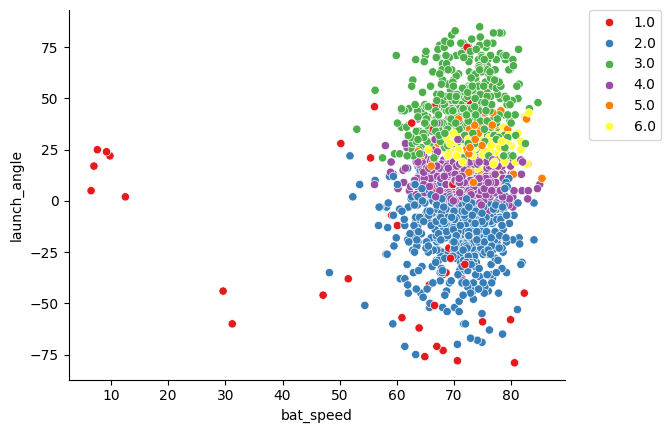

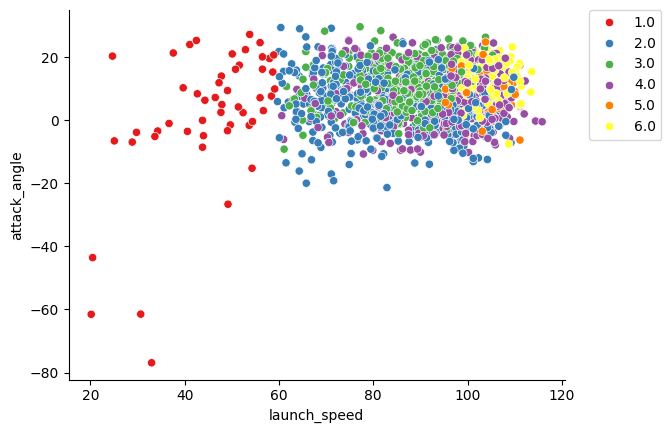

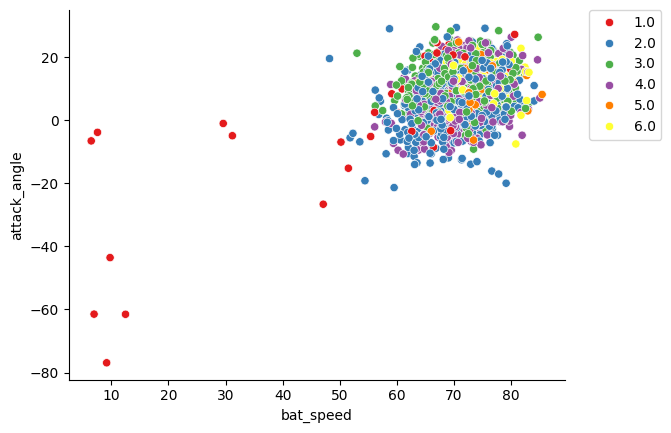

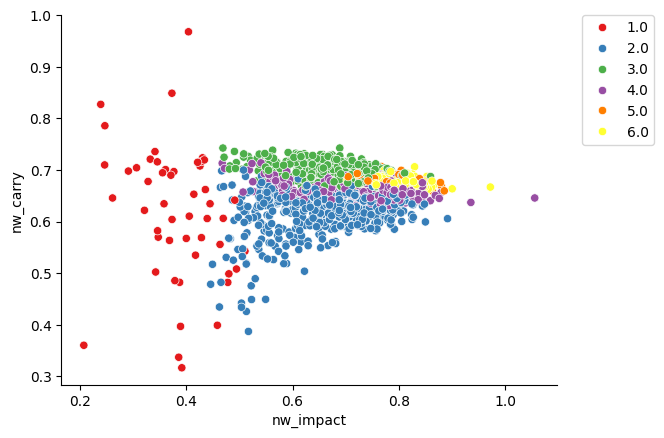

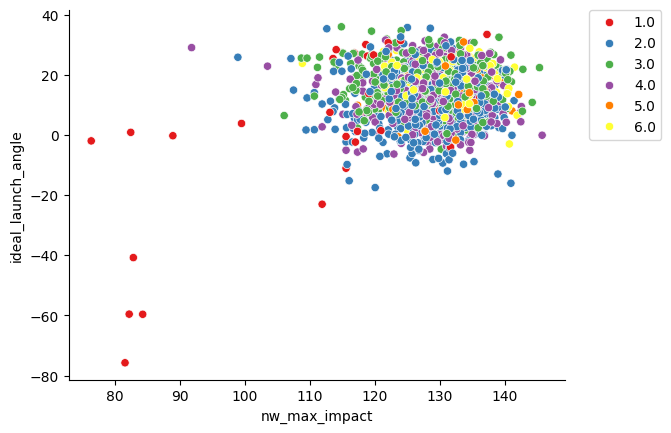

In [ ]:
# df_plt = df.loc[df['nw_impact']>.7].sample(10000)
# df_plt = df.loc[df['ximpact']>.6].sample(10000)
# df_plt = df.loc[df['attack_angle'].between(5,20)].sample(10000)
df_plt = df.sample(10000)
sns.scatterplot(data=df_plt,x='launch_speed',y='launch_angle',
                hue='launch_speed_angle',palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

sns.scatterplot(data=df_plt,x='bat_speed',y='launch_angle',
                hue='launch_speed_angle',palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

sns.scatterplot(data=df_plt,x='launch_speed',y='attack_angle',
                hue='launch_speed_angle',palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

sns.scatterplot(data=df_plt,x='bat_speed',y='attack_angle',
                hue='launch_speed_angle',palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

sns.scatterplot(data=df_plt,x='nw_impact',y='nw_carry',
                hue='launch_speed_angle',palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

sns.scatterplot(data=df_plt,x='nw_max_impact',y='ideal_launch_angle',
                hue='launch_speed_angle',palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

In [ ]:
cols = [
    'batter', 'launch_speed','launch_angle','delta_run_exp',
    'bat_speed','attack_angle','nw_impact','nw_carry'
]
df_agg = df.loc[:, cols].groupby(['batter'], as_index=False).mean()
_df_agg = df.loc[:, cols].groupby(['batter'], as_index=False).sum()
_df_agg1 = df.loc[:, ['batter','pitcher']].groupby(['batter'], as_index=False).count().rename(columns={'pitcher':'pitches_seen'})
df_agg = df_agg.merge(_df_agg1, on='batter')
df_agg = df_agg.drop(['delta_run_exp'], axis=1)
df_agg = df_agg.merge(_df_agg.loc[:, ['batter','delta_run_exp']], on='batter')
qt = QuantileTransformer(n_quantiles=100, output_distribution='normal')
s = pd.DataFrame(qt.fit_transform(df_agg.loc[:, ['delta_run_exp']]), index=df_agg.index)[0]
df_agg['rv_pct'] = s
ids = bb.playerid_reverse_lookup(df_agg['batter'].unique())
ids['batter_name'] = ids['name_last'].add(', ').add(ids['name_first'])
df_agg = ids.loc[:, ['key_mlbam','batter_name']].merge(df_agg, right_on='batter', left_on='key_mlbam')
df_agg.head()

<IPython.core.display.Javascript object>

Gathering player lookup table. This may take a moment.


,key_mlbam,batter_name,batter,launch_speed,launch_angle,bat_speed,attack_angle,nw_impact,nw_carry,pitches_seen,delta_run_exp,rv_pct
0,680911,"miller, owen",680911,80.836364,21.409091,69.195745,5.545832,0.638438,0.67023,138,-2.557,-1.091014
1,669242,"edman, tommy",669242,83.743071,13.243446,68.562195,8.607146,0.65901,0.658334,724,2.47,1.199687
2,676914,"schneider, davis",676914,84.670833,20.854167,68.692,16.383306,0.628369,0.66246,205,0.927,0.865449
3,702332,"durbin, caleb",702332,80.248869,18.981982,65.5672,7.077066,0.635091,0.663332,678,-4.951,-1.445876
4,670032,"lopez, nicky",670032,78.716216,6.297297,64.621739,6.917615,0.625335,0.6425,106,-3.658,-1.246904


<IPython.core.display.Javascript object>

,rv_pct
count,558.000000
mean,-0.111433
std,1.431529
min,-5.199338
25%,-1.283746
50%,-0.634821
75%,1.274363
max,5.199338


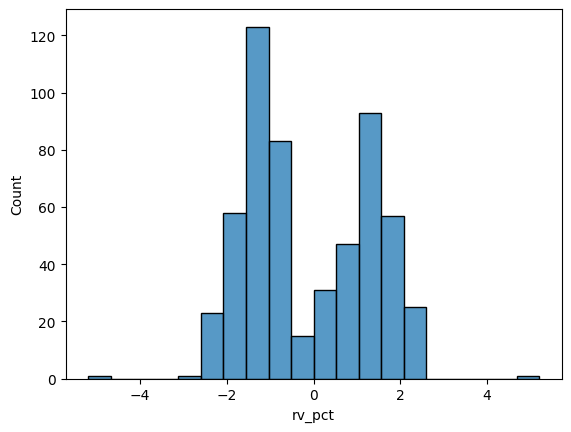

In [ ]:
sns.histplot(df_agg.loc[df_agg['pitches_seen']>50,'rv_pct'],bins=20)
df_agg.loc[df_agg['pitches_seen']>50,'rv_pct'].describe()

In [ ]:
df.columns.values

<IPython.core.display.Javascript object>

array(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year',
       'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle',
       'effective_speed', 'release_spin_rate', 'release_extension',
       'game_pk', 'fielder_2', 'fielder_3', 'fielder_4', 'fielder_5',
       'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9',
       'release_pos_y', 'estimated_ba_using_speedangle',
  

# attack angle research

In [ ]:
df.head()

<IPython.core.display.Javascript object>

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,nw_max_impact,nw_impact,ximpact,ideal_launch_angle,nw_carry
0,FC,2025-06-09,87.9,1.48,5.59,"Seymour, Ian",678882,693855,field_out,hit_into_play,...,13.914185,4.926222,37.451356,28.7269,30.243957,129.36,0.82483,0.663559,19.609894,0.651928
1,FF,2025-06-09,89.1,1.53,5.55,"Seymour, Ian",663853,693855,strikeout,called_strike,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>
2,CH,2025-06-09,79.5,1.26,5.69,"Seymour, Ian",663853,693855,NaN,ball,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>
3,FF,2025-06-09,89.4,1.39,5.59,"Seymour, Ian",663853,693855,NaN,called_strike,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>
4,FC,2025-06-09,86.8,1.29,5.52,"Seymour, Ian",663853,693855,NaN,ball,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,<NA>,<NA>


<IPython.core.display.Javascript object>

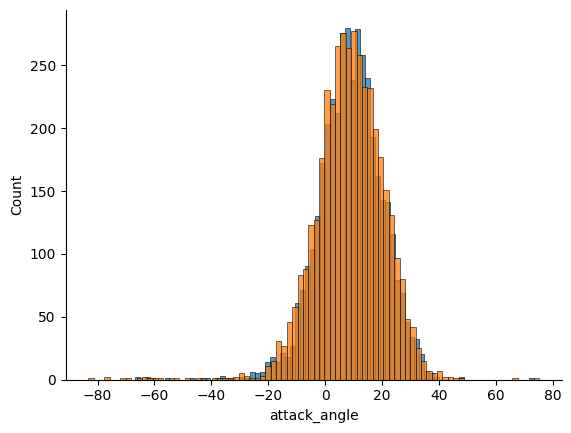

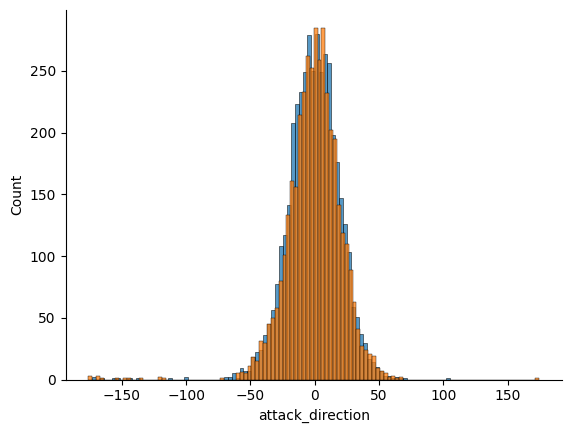

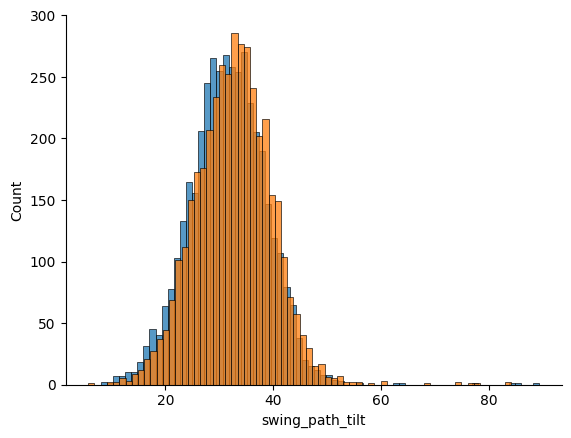

In [ ]:
ys = [
    'attack_angle', 'attack_direction', 'swing_path_tilt'
]
for y in ys:
  sns.histplot(df.loc[df['stand']=='R',y].sample(10000), label='R')
  sns.histplot(df.loc[df['stand']=='L',y].sample(10000), label='L')
  sns.despine()
  plt.show()

In [ ]:
df_plt.head()

<IPython.core.display.Javascript object>

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,nw_max_impact,nw_impact,ximpact,ideal_launch_angle,nw_carry,attack_zone
38,FF,2025-06-09,89.6,1.31,5.36,"Seymour, Ian",596115,693855,field_out,hit_into_play,...,-0.129381,28.560697,37.780075,31.088305,129.12,0.760533,0.659822,13.485441,0.699688,heart
77,FF,2025-06-09,97.9,0.03,6.9,"Fairbanks, Pete",596115,664126,field_out,hit_into_play,...,-4.542024,35.239105,40.742921,32.114327,133.36,0.65237,0.545428,17.667281,0.704681,heart
80,FF,2025-06-09,97.4,-0.17,6.85,"Fairbanks, Pete",647351,664126,double,hit_into_play,...,9.196858,29.854109,41.686971,33.113314,132.32,0.733827,0.697285,12.791287,0.691468,heart
92,FF,2025-06-09,94.3,-1.54,5.84,"Guerrero, Luis",666018,692285,sac_fly,hit_into_play,...,0.212255,35.217169,32.728316,29.485464,131.68,0.777643,0.645422,20.71843,0.680713,heart
121,FF,2025-06-09,96.6,-1.03,5.36,"Rodríguez, Manuel",666152,655889,field_out,hit_into_play,...,5.360386,33.924046,32.779805,25.227886,136.72,0.393505,0.574624,2.918162,0.737914,heart


In [ ]:
pt = 'FF'
df_plt = df.loc[(df['pitch_type']==pt) & (df['description']=='hit_into_play') & (df['attack_zone']=='heart')]
_df = df_plt.loc[:, ['batter', 'attack_angle', 'attack_direction', 'swing_path_tilt']].groupby('batter',as_index=False).mean()
df_plt = df.merge(_df, on='batter', suffixes=('','_mmfb'))


<IPython.core.display.Javascript object>

In [ ]:
ys = [
    'attack_angle', 'attack_direction', 'swing_path_tilt'
]
for y in ys:
  df_plt[f'{y}_diff'] = df_plt[f'{y}'].sub(df_plt[f'{y}_mmfb'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

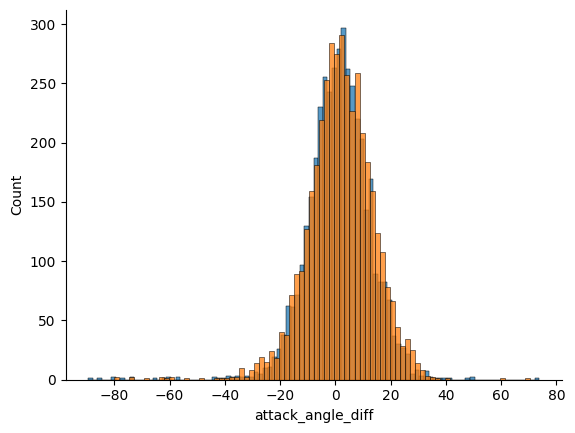

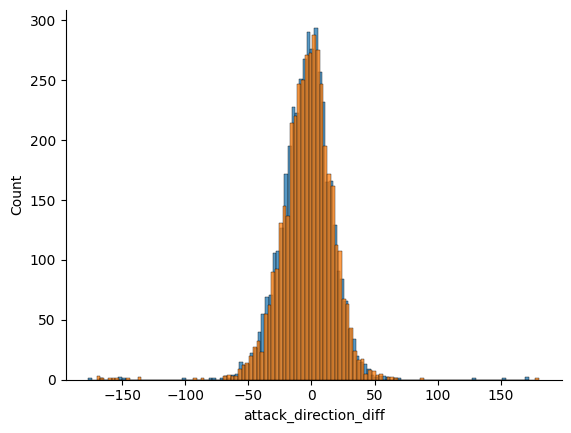

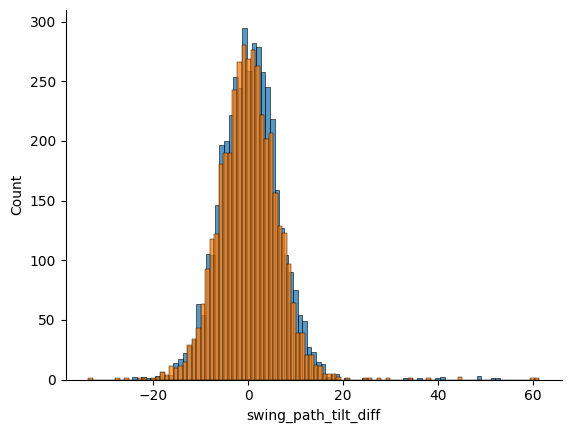

In [ ]:
ys = [
    'attack_angle_diff', 'attack_direction_diff', 'swing_path_tilt_diff'
]
for y in ys:
  sns.histplot(df_plt.loc[df_plt['stand']=='R',y].sample(10000), label='R')
  sns.histplot(df_plt.loc[df_plt['stand']=='L',y].sample(10000), label='L')
  sns.despine()
  plt.show()

<IPython.core.display.Javascript object>

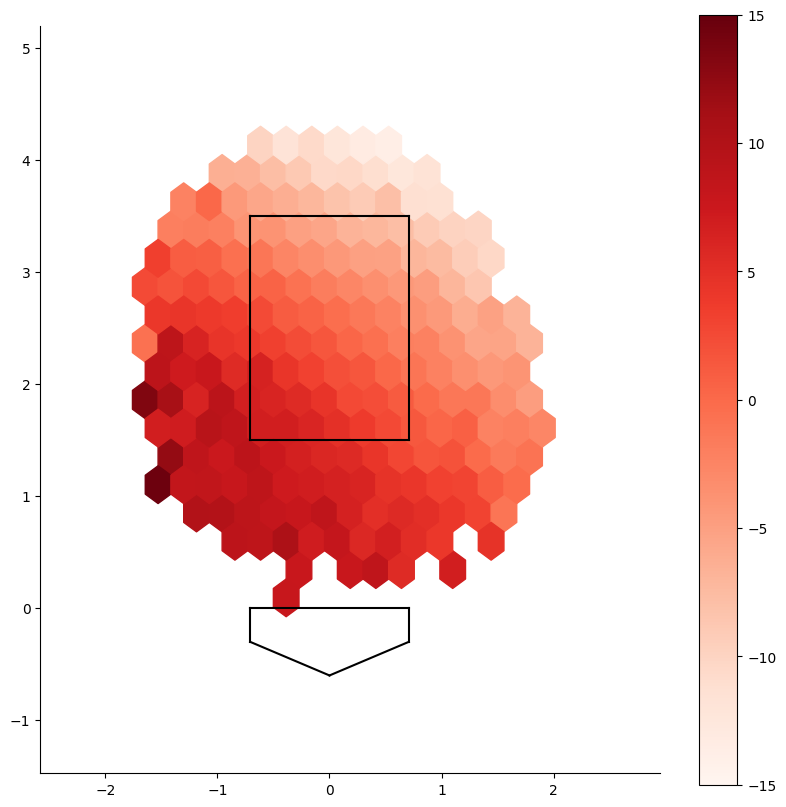

In [ ]:
_df = df_plt.loc[df_plt['stand']=='R'].sample(50000)
x='plate_x'
y='plate_z'
hue='swing_path_tilt_diff'

for col in [x,y,hue]:
  _df[col] = _df[col].astype(float)

fig = plt.figure(figsize=(10,10))
plt.hexbin(data=_df,x=x,y=y,C=hue,cmap='Reds',gridsize=22,mincnt=5,vmin=-15,vmax=15)
sns.despine()
draw_sz()
draw_home_plate()
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()